## Import packages

In [1]:
library(rpart)
library(rpart.plot)
library(randomForest)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


## Import loans data
To predict credit card default.

In [2]:
loans = read.csv("data/loans.csv")
head(loans)
str(loans)

loan_amount,emp_length,home_ownership,income,loan_purpose,debt_to_income,credit_score,recent_inquiry,delinquent,credit_accounts,bad_public_record,credit_utilization,past_bankrupt,outcome
LOW,10+ years,RENT,LOW,credit_card,HIGH,AVERAGE,YES,NEVER,FEW,NO,HIGH,NO,default
LOW,< 2 years,RENT,LOW,car,LOW,AVERAGE,YES,NEVER,FEW,NO,LOW,NO,repaid
LOW,10+ years,RENT,LOW,small_business,AVERAGE,AVERAGE,YES,NEVER,FEW,NO,HIGH,NO,default
MEDIUM,10+ years,RENT,MEDIUM,other,HIGH,AVERAGE,YES,MORE THAN 2 YEARS AGO,AVERAGE,NO,LOW,NO,default
LOW,< 2 years,RENT,HIGH,other,AVERAGE,AVERAGE,NO,MORE THAN 2 YEARS AGO,MANY,NO,MEDIUM,NO,default
LOW,2 - 5 years,RENT,LOW,wedding,AVERAGE,AVERAGE,YES,NEVER,AVERAGE,NO,MEDIUM,NO,default


'data.frame':	11297 obs. of  14 variables:
 $ loan_amount       : Factor w/ 3 levels "HIGH","LOW","MEDIUM": 2 2 2 3 2 2 3 2 3 2 ...
 $ emp_length        : Factor w/ 5 levels "< 2 years","10+ years",..: 2 1 2 2 1 3 4 4 3 1 ...
 $ home_ownership    : Factor w/ 4 levels "MORTGAGE","OTHER",..: 4 4 4 4 4 4 4 4 3 4 ...
 $ income            : Factor w/ 3 levels "HIGH","LOW","MEDIUM": 2 2 2 3 1 2 3 3 3 2 ...
 $ loan_purpose      : Factor w/ 14 levels "car","credit_card",..: 2 1 12 10 10 14 3 1 12 10 ...
 $ debt_to_income    : Factor w/ 3 levels "AVERAGE","HIGH",..: 2 3 1 2 1 1 2 3 3 1 ...
 $ credit_score      : Factor w/ 3 levels "AVERAGE","HIGH",..: 1 1 1 1 1 1 1 3 1 1 ...
 $ recent_inquiry    : Factor w/ 2 levels "NO","YES": 2 2 2 2 1 2 2 2 2 1 ...
 $ delinquent        : Factor w/ 3 levels "IN PAST 2 YEARS",..: 3 3 3 2 2 3 3 3 3 3 ...
 $ credit_accounts   : Factor w/ 3 levels "AVERAGE","FEW",..: 2 2 2 1 3 1 1 2 1 2 ...
 $ bad_public_record : Factor w/ 2 levels "NO","YES": 1 1 1 1 1 1 1 1 1 1

## Number of default vs repaid data

In [3]:
table(loans$outcome)


default  repaid 
   5646    5651 

## Split into training & testing dataset
Here we use 75% data at random for training and the remaining 25% for testing

In [4]:
total = nrow(loans)
train = total * 0.75
sample_rows = sample(total, train)
loans_train = loans[sample_rows,]
loans_test = loans[-sample_rows,]
print(paste("Number of training data:", nrow(loans_train)))
print(paste("Number of testing data:", nrow(loans_test)))

[1] "Number of training data: 8472"
[1] "Number of testing data: 2825"


## Create decision tree model

In [5]:
loan_model = rpart(outcome ~ loan_amount + credit_score, data = loans, method = "class", control = rpart.control(cp = 0))
loan_pred = predict(loan_model, loans, type = "class")

print("Decision tree model:")
loan_model
print("Confusion matrix:")
table(loans$outcome, loan_pred)
print(paste("Accuracy:", mean(loans$outcome == loan_pred)))

[1] "Decision tree model:"


n= 11297 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 11297 5646 repaid (0.4997787 0.5002213)  
   2) credit_score=HIGH 1623  601 default (0.6296981 0.3703019) *
   3) credit_score=AVERAGE,LOW 9674 4624 repaid (0.4779822 0.5220178)  
     6) credit_score=AVERAGE 8007 3992 repaid (0.4985638 0.5014362)  
      12) loan_amount=HIGH,MEDIUM 6323 3079 default (0.5130476 0.4869524)  
        24) loan_amount=MEDIUM 3588 1688 default (0.5295429 0.4704571) *
        25) loan_amount=HIGH 2735 1344 repaid (0.4914077 0.5085923) *
      13) loan_amount=LOW 1684  748 repaid (0.4441805 0.5558195) *
     7) credit_score=LOW 1667  632 repaid (0.3791242 0.6208758) *

[1] "Confusion matrix:"


         loan_pred
          default repaid
  default    2922   2724
  repaid     2289   3362

[1] "Accuracy: 0.556253872709569"


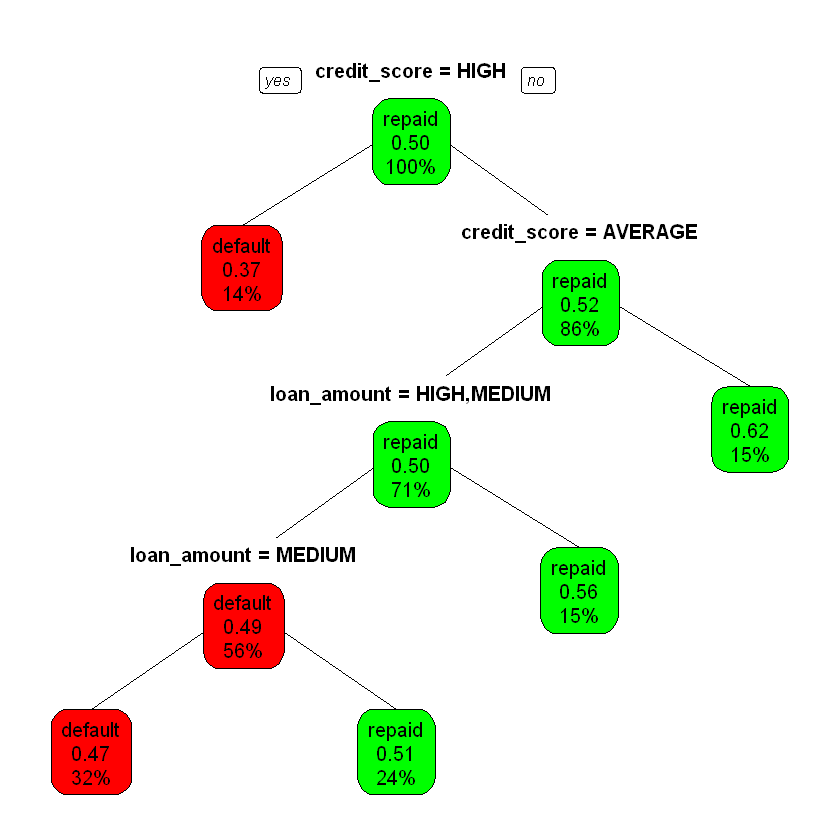

In [6]:
rpart.plot(loan_model, type = 1, box.palette = c("red", "green"), fallen.leaves = FALSE)

## Pre-Pruning
Defines maximum depth or minimum observation to split to improve accuracy as in preventing overgrown trees

In [7]:
accuracy = function(model){
    pred = predict(model, loans_test, type = "class")
    return(mean(pred == loans_test$outcome))
}

loan_model = rpart(outcome ~ ., data = loans_train, method = "class", control = rpart.control(cp = 0))
loan_model_maxdepth = rpart(outcome ~ ., data = loans_train, method = "class", control = rpart.control(cp = 0, maxdepth = 6))
loan_model_minsplit = rpart(outcome ~ ., data = loans_train, method = "class", control = rpart.control(cp = 0, minsplit = 500))

paste("Accuracy for non-pruning model: ", accuracy(loan_model))
paste("Accuracy for max depth pruning model: ", accuracy(loan_model_maxdepth))
paste("Accuracy for min split pruning model: ", accuracy(loan_model_minsplit))

[1] "Accuracy for non-pruning model:  0.571681415929204"

[1] "Accuracy for max depth pruning model:  0.597522123893805"

[1] "Accuracy for min split pruning model:  0.609557522123894"

## Post-Pruning
Grow a large and complex tree then prune it to be smaller and more efficient tree.   
Use complexity plot to determine where to prune.

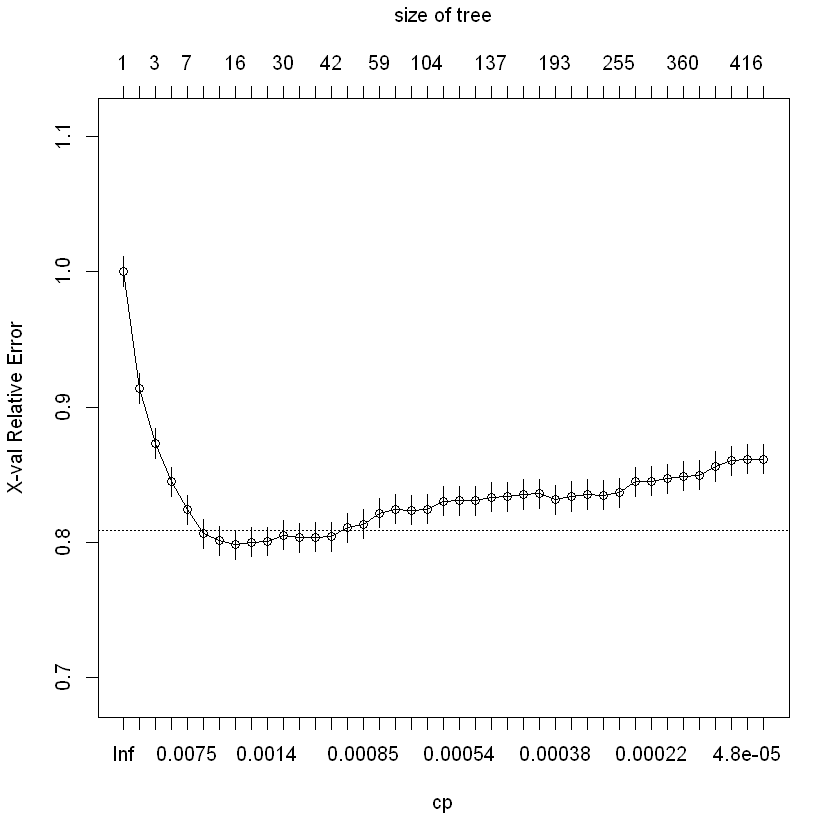

In [8]:
loan_model <- rpart(outcome ~ ., data = loans_train, method = "class", control = rpart.control(cp = 0))
plotcp(loan_model)

In [9]:
# Let's take 0.0014 as example
loan_model_pruned = prune(loan_model, cp = 0.0014)
paste("Accuracy for post-pruned model: ", accuracy(loan_model_pruned))

[1] "Accuracy for post-pruned model:  0.608495575221239"

## Random forest
Random forests uses ensemble to generate a single prediction by allowing the trees to "vote" on the outcome.    
Teamwork-based approach of the random forest may help it find important trends a single tree may miss.

In [10]:
loan_model_random_forest <- randomForest(outcome ~ ., data = loans_train)
paste("Accuracy for random forest model: ", accuracy(loan_model_random_forest))

[1] "Accuracy for random forest model:  0.603185840707965"